# 03. Modeling - Advanced Version
## Spaceship Titanic - Kaggle Competition

이 노트북에서는 다양한 모델과 Optuna 하이퍼파라미터 튜닝, 고급 앙상블 기법을 활용합니다.

### 포함된 개선 사항
1. **Optuna 하이퍼파라미터 튜닝**: LightGBM, XGBoost, CatBoost 최적화
2. **추가 모델**: RandomForest, ExtraTrees, HistGradientBoosting
3. **다양한 앙상블**: Optuna 가중치 최적화, 다층 스태킹

## 1. 라이브러리 Import 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
from time import time

# 모델
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# sklearn 모델
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier, 
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# sklearn 유틸리티
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Optuna
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
np.random.seed(42)

# 저장 디렉토리 생성
os.makedirs('../submissions', exist_ok=True)
os.makedirs('../models', exist_ok=True)

c:\Users\park0\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 전처리된 데이터 로드
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test.csv')
test_ids = pd.read_csv('../data/processed/test_ids.csv').values.ravel()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTarget 분포: {np.bincount(y_train)}")

X_train shape: (8693, 62)
y_train shape: (8693,)
X_test shape: (4277, 62)

Target 분포: [4315 4378]


## 2. Cross-Validation 설정 및 유틸리티 함수

In [3]:
# Stratified K-Fold 설정
N_FOLDS = 5
RANDOM_STATE = 42
N_OPTUNA_TRIALS = 50  # Optuna 시도 횟수

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# 결과 저장용
cv_results = {}
oof_predictions = {}
test_predictions = {}

In [4]:
def train_and_evaluate(model, model_name, X_train, y_train, X_test, skf, 
                       use_early_stopping=False, verbose=True):
    """
    Cross-validation으로 모델 학습 및 평가
    """
    oof_preds = np.zeros(len(X_train))
    oof_probs = np.zeros(len(X_train))
    test_probs = np.zeros(len(X_test))
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # 모델 복제
        if hasattr(model, 'get_params'):
            params = model.get_params()
            model_fold = model.__class__(**params)
        else:
            model_fold = model.__class__()
        
        # 학습
        if use_early_stopping:
            if 'LGBM' in model_name or 'LightGBM' in model_name:
                model_fold.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            elif 'XGB' in model_name or 'XGBoost' in model_name:
                model_fold.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            elif 'CatBoost' in model_name:
                model_fold.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)
            else:
                model_fold.fit(X_tr, y_tr)
        else:
            if 'CatBoost' in model_name:
                model_fold.fit(X_tr, y_tr, verbose=False)
            else:
                model_fold.fit(X_tr, y_tr)
        
        # Validation 예측
        val_preds = model_fold.predict(X_val)
        val_probs = model_fold.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = val_preds
        oof_probs[val_idx] = val_probs
        
        # Test 예측
        test_probs += model_fold.predict_proba(X_test)[:, 1] / N_FOLDS
        
        # Fold 점수
        fold_acc = accuracy_score(y_val, val_preds)
        fold_scores.append(fold_acc)
        
        if verbose:
            print(f"  Fold {fold}: Accuracy = {fold_acc:.4f}")
    
    # 전체 OOF 점수
    oof_acc = accuracy_score(y_train, oof_preds)
    oof_auc = roc_auc_score(y_train, oof_probs)
    
    if verbose:
        print(f"\n  OOF Accuracy: {oof_acc:.4f}")
        print(f"  OOF AUC: {oof_auc:.4f}")
        print(f"  Mean CV: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")
    
    return {
        'oof_preds': oof_preds,
        'oof_probs': oof_probs,
        'test_probs': test_probs,
        'oof_acc': oof_acc,
        'oof_auc': oof_auc,
        'fold_scores': fold_scores
    }

---
# Part 1: Optuna 하이퍼파라미터 튜닝
---

## 3. LightGBM Optuna 튜닝

In [5]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("LightGBM Optuna 하이퍼파라미터 튜닝")
print("="*60)

sampler = TPESampler(seed=RANDOM_STATE)
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective_lgb, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)

print(f"\nBest LightGBM Score: {study_lgb.best_value:.4f}")
print(f"Best Parameters: {study_lgb.best_params}")

LightGBM Optuna 하이퍼파라미터 튜닝


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.801217:   0%|          | 0/50 [00:07<?, ?it/s]

Best trial: 0. Best value: 0.801217:   2%|▏         | 1/50 [00:07<06:07,  7.51s/it]

Best trial: 1. Best value: 0.812722:   2%|▏         | 1/50 [00:23<06:07,  7.51s/it]

Best trial: 1. Best value: 0.812722:   4%|▍         | 2/50 [00:23<09:48, 12.25s/it]

Best trial: 1. Best value: 0.812722:   4%|▍         | 2/50 [00:28<09:48, 12.25s/it]

Best trial: 1. Best value: 0.812722:   6%|▌         | 3/50 [00:28<07:08,  9.13s/it]

Best trial: 1. Best value: 0.812722:   6%|▌         | 3/50 [00:31<07:08,  9.13s/it]

Best trial: 1. Best value: 0.812722:   8%|▊         | 4/50 [00:31<05:07,  6.69s/it]

Best trial: 4. Best value: 0.816864:   8%|▊         | 4/50 [00:38<05:07,  6.69s/it]

Best trial: 4. Best value: 0.816864:  10%|█         | 5/50 [00:38<05:02,  6.72s/it]

Best trial: 4. Best value: 0.816864:  10%|█         | 5/50 [00:46<05:02,  6.72s/it]

Best trial: 4. Best value: 0.816864:  12%|█▏        | 6/50 [00:46<05:12,  7.09s/it]

Best trial: 4. Best value: 0.816864:  12%|█▏        | 6/50 [00:47<05:12,  7.09s/it]

Best trial: 4. Best value: 0.816864:  14%|█▍        | 7/50 [00:47<03:45,  5.26s/it]

Best trial: 4. Best value: 0.816864:  14%|█▍        | 7/50 [00:50<03:45,  5.26s/it]

Best trial: 4. Best value: 0.816864:  16%|█▌        | 8/50 [00:50<03:08,  4.50s/it]

Best trial: 4. Best value: 0.816864:  16%|█▌        | 8/50 [00:51<03:08,  4.50s/it]

Best trial: 4. Best value: 0.816864:  18%|█▊        | 9/50 [00:51<02:19,  3.39s/it]

Best trial: 4. Best value: 0.816864:  18%|█▊        | 9/50 [00:52<02:19,  3.39s/it]

Best trial: 4. Best value: 0.816864:  20%|██        | 10/50 [00:52<01:53,  2.83s/it]

Best trial: 4. Best value: 0.816864:  20%|██        | 10/50 [00:58<01:53,  2.83s/it]

Best trial: 4. Best value: 0.816864:  22%|██▏       | 11/50 [00:58<02:17,  3.52s/it]

Best trial: 4. Best value: 0.816864:  22%|██▏       | 11/50 [00:59<02:17,  3.52s/it]

Best trial: 4. Best value: 0.816864:  24%|██▍       | 12/50 [00:59<01:48,  2.87s/it]

Best trial: 4. Best value: 0.816864:  24%|██▍       | 12/50 [01:02<01:48,  2.87s/it]

Best trial: 4. Best value: 0.816864:  26%|██▌       | 13/50 [01:02<01:52,  3.05s/it]

Best trial: 4. Best value: 0.816864:  26%|██▌       | 13/50 [01:07<01:52,  3.05s/it]

Best trial: 4. Best value: 0.816864:  28%|██▊       | 14/50 [01:07<02:08,  3.58s/it]

Best trial: 4. Best value: 0.816864:  28%|██▊       | 14/50 [01:13<02:08,  3.58s/it]

Best trial: 4. Best value: 0.816864:  30%|███       | 15/50 [01:13<02:30,  4.31s/it]

Best trial: 4. Best value: 0.816864:  30%|███       | 15/50 [01:17<02:30,  4.31s/it]

Best trial: 4. Best value: 0.816864:  32%|███▏      | 16/50 [01:17<02:20,  4.12s/it]

Best trial: 4. Best value: 0.816864:  32%|███▏      | 16/50 [01:20<02:20,  4.12s/it]

Best trial: 4. Best value: 0.816864:  34%|███▍      | 17/50 [01:20<02:02,  3.71s/it]

Best trial: 4. Best value: 0.816864:  34%|███▍      | 17/50 [01:23<02:02,  3.71s/it]

Best trial: 4. Best value: 0.816864:  36%|███▌      | 18/50 [01:23<01:53,  3.55s/it]

Best trial: 4. Best value: 0.816864:  36%|███▌      | 18/50 [01:29<01:53,  3.55s/it]

Best trial: 4. Best value: 0.816864:  38%|███▊      | 19/50 [01:29<02:10,  4.21s/it]

Best trial: 4. Best value: 0.816864:  38%|███▊      | 19/50 [01:31<02:10,  4.21s/it]

Best trial: 4. Best value: 0.816864:  40%|████      | 20/50 [01:31<01:51,  3.72s/it]

Best trial: 4. Best value: 0.816864:  40%|████      | 20/50 [01:35<01:51,  3.72s/it]

Best trial: 4. Best value: 0.816864:  42%|████▏     | 21/50 [01:35<01:51,  3.85s/it]

Best trial: 4. Best value: 0.816864:  42%|████▏     | 21/50 [01:41<01:51,  3.85s/it]

Best trial: 4. Best value: 0.816864:  44%|████▍     | 22/50 [01:41<02:05,  4.47s/it]

Best trial: 4. Best value: 0.816864:  44%|████▍     | 22/50 [01:48<02:05,  4.47s/it]

Best trial: 4. Best value: 0.816864:  46%|████▌     | 23/50 [01:48<02:21,  5.24s/it]

Best trial: 4. Best value: 0.816864:  46%|████▌     | 23/50 [02:00<02:21,  5.24s/it]

Best trial: 4. Best value: 0.816864:  48%|████▊     | 24/50 [02:00<03:08,  7.26s/it]

Best trial: 4. Best value: 0.816864:  48%|████▊     | 24/50 [02:04<03:08,  7.26s/it]

Best trial: 4. Best value: 0.816864:  50%|█████     | 25/50 [02:04<02:35,  6.23s/it]

Best trial: 4. Best value: 0.816864:  50%|█████     | 25/50 [02:07<02:35,  6.23s/it]

Best trial: 4. Best value: 0.816864:  52%|█████▏    | 26/50 [02:07<02:03,  5.16s/it]

Best trial: 4. Best value: 0.816864:  52%|█████▏    | 26/50 [02:08<02:03,  5.16s/it]

Best trial: 4. Best value: 0.816864:  54%|█████▍    | 27/50 [02:08<01:31,  3.98s/it]

Best trial: 4. Best value: 0.816864:  54%|█████▍    | 27/50 [02:10<01:31,  3.98s/it]

Best trial: 4. Best value: 0.816864:  56%|█████▌    | 28/50 [02:10<01:15,  3.41s/it]

Best trial: 4. Best value: 0.816864:  56%|█████▌    | 28/50 [02:14<01:15,  3.41s/it]

Best trial: 4. Best value: 0.816864:  58%|█████▊    | 29/50 [02:14<01:12,  3.48s/it]

Best trial: 4. Best value: 0.816864:  58%|█████▊    | 29/50 [02:15<01:12,  3.48s/it]

Best trial: 4. Best value: 0.816864:  60%|██████    | 30/50 [02:15<00:58,  2.91s/it]

Best trial: 4. Best value: 0.816864:  60%|██████    | 30/50 [02:21<00:58,  2.91s/it]

Best trial: 4. Best value: 0.816864:  62%|██████▏   | 31/50 [02:21<01:12,  3.81s/it]

Best trial: 4. Best value: 0.816864:  62%|██████▏   | 31/50 [02:25<01:12,  3.81s/it]

Best trial: 4. Best value: 0.816864:  64%|██████▍   | 32/50 [02:25<01:09,  3.86s/it]

Best trial: 4. Best value: 0.816864:  64%|██████▍   | 32/50 [02:29<01:09,  3.86s/it]

Best trial: 4. Best value: 0.816864:  66%|██████▌   | 33/50 [02:29<01:08,  4.01s/it]

Best trial: 4. Best value: 0.816864:  66%|██████▌   | 33/50 [02:34<01:08,  4.01s/it]

Best trial: 4. Best value: 0.816864:  68%|██████▊   | 34/50 [02:34<01:08,  4.28s/it]

Best trial: 4. Best value: 0.816864:  68%|██████▊   | 34/50 [02:37<01:08,  4.28s/it]

Best trial: 4. Best value: 0.816864:  70%|███████   | 35/50 [02:37<00:55,  3.69s/it]

Best trial: 4. Best value: 0.816864:  70%|███████   | 35/50 [02:41<00:55,  3.69s/it]

Best trial: 4. Best value: 0.816864:  72%|███████▏  | 36/50 [02:41<00:52,  3.77s/it]

Best trial: 4. Best value: 0.816864:  72%|███████▏  | 36/50 [02:44<00:52,  3.77s/it]

Best trial: 4. Best value: 0.816864:  74%|███████▍  | 37/50 [02:44<00:47,  3.66s/it]

Best trial: 4. Best value: 0.816864:  74%|███████▍  | 37/50 [02:50<00:47,  3.66s/it]

Best trial: 4. Best value: 0.816864:  76%|███████▌  | 38/50 [02:50<00:50,  4.22s/it]

Best trial: 4. Best value: 0.816864:  76%|███████▌  | 38/50 [02:58<00:50,  4.22s/it]

Best trial: 4. Best value: 0.816864:  78%|███████▊  | 39/50 [02:58<01:01,  5.61s/it]

Best trial: 4. Best value: 0.816864:  78%|███████▊  | 39/50 [03:03<01:01,  5.61s/it]

Best trial: 4. Best value: 0.816864:  80%|████████  | 40/50 [03:03<00:52,  5.28s/it]

Best trial: 4. Best value: 0.816864:  80%|████████  | 40/50 [03:04<00:52,  5.28s/it]

Best trial: 4. Best value: 0.816864:  82%|████████▏ | 41/50 [03:04<00:36,  4.01s/it]

Best trial: 4. Best value: 0.816864:  82%|████████▏ | 41/50 [03:08<00:36,  4.01s/it]

Best trial: 4. Best value: 0.816864:  84%|████████▍ | 42/50 [03:08<00:31,  3.91s/it]

Best trial: 42. Best value: 0.817324:  84%|████████▍ | 42/50 [03:10<00:31,  3.91s/it]

Best trial: 42. Best value: 0.817324:  86%|████████▌ | 43/50 [03:10<00:24,  3.48s/it]

Best trial: 42. Best value: 0.817324:  86%|████████▌ | 43/50 [03:13<00:24,  3.48s/it]

Best trial: 42. Best value: 0.817324:  88%|████████▊ | 44/50 [03:13<00:20,  3.43s/it]

Best trial: 42. Best value: 0.817324:  88%|████████▊ | 44/50 [03:16<00:20,  3.43s/it]

Best trial: 42. Best value: 0.817324:  90%|█████████ | 45/50 [03:16<00:15,  3.09s/it]

Best trial: 42. Best value: 0.817324:  90%|█████████ | 45/50 [03:18<00:15,  3.09s/it]

Best trial: 42. Best value: 0.817324:  92%|█████████▏| 46/50 [03:18<00:11,  2.89s/it]

Best trial: 42. Best value: 0.817324:  92%|█████████▏| 46/50 [03:20<00:11,  2.89s/it]

Best trial: 42. Best value: 0.817324:  94%|█████████▍| 47/50 [03:20<00:07,  2.52s/it]

Best trial: 42. Best value: 0.817324:  94%|█████████▍| 47/50 [03:21<00:07,  2.52s/it]

Best trial: 42. Best value: 0.817324:  96%|█████████▌| 48/50 [03:21<00:04,  2.18s/it]

Best trial: 42. Best value: 0.817324:  96%|█████████▌| 48/50 [03:24<00:04,  2.18s/it]

Best trial: 42. Best value: 0.817324:  98%|█████████▊| 49/50 [03:24<00:02,  2.40s/it]

Best trial: 42. Best value: 0.817324:  98%|█████████▊| 49/50 [03:27<00:02,  2.40s/it]

Best trial: 42. Best value: 0.817324: 100%|██████████| 50/50 [03:27<00:00,  2.51s/it]

Best trial: 42. Best value: 0.817324: 100%|██████████| 50/50 [03:27<00:00,  4.15s/it]


Best LightGBM Score: 0.8173
Best Parameters: {'n_estimators': 245, 'learning_rate': 0.01956730973408462, 'max_depth': 8, 'num_leaves': 35, 'min_child_samples': 10, 'subsample': 0.629647537607878, 'colsample_bytree': 0.5434165368974109, 'reg_alpha': 1.7132799922767854e-06, 'reg_lambda': 0.0003498721635113478}


In [6]:
# 최적 파라미터로 LightGBM 학습
lgb_best_params = study_lgb.best_params.copy()
lgb_best_params['random_state'] = RANDOM_STATE
lgb_best_params['n_jobs'] = -1
lgb_best_params['verbosity'] = -1

lgb_tuned = lgb.LGBMClassifier(**lgb_best_params)

print("\nLightGBM (Tuned) 학습 결과:")
lgb_results = train_and_evaluate(lgb_tuned, 'LightGBM_Tuned', X_train, y_train, X_test, skf)

cv_results['LightGBM_Tuned'] = lgb_results
oof_predictions['LightGBM_Tuned'] = lgb_results['oof_probs']
test_predictions['LightGBM_Tuned'] = lgb_results['test_probs']


LightGBM (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8240


  Fold 2: Accuracy = 0.8056


  Fold 3: Accuracy = 0.8263


  Fold 4: Accuracy = 0.8251


  Fold 5: Accuracy = 0.8055

  OOF Accuracy: 0.8173
  OOF AUC: 0.9053
  Mean CV: 0.8173 (+/- 0.0096)


## 4. XGBoost Optuna 튜닝

In [7]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }
    
    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("XGBoost Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)

print(f"\nBest XGBoost Score: {study_xgb.best_value:.4f}")
print(f"Best Parameters: {study_xgb.best_params}")

XGBoost Optuna 하이퍼파라미터 튜닝


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.805589:   0%|          | 0/50 [00:01<?, ?it/s]

Best trial: 0. Best value: 0.805589:   2%|▏         | 1/50 [00:01<01:06,  1.37s/it]

Best trial: 1. Best value: 0.808352:   2%|▏         | 1/50 [00:03<01:06,  1.37s/it]

Best trial: 1. Best value: 0.808352:   4%|▍         | 2/50 [00:03<01:17,  1.62s/it]

Best trial: 2. Best value: 0.812608:   4%|▍         | 2/50 [00:04<01:17,  1.62s/it]

Best trial: 2. Best value: 0.812608:   6%|▌         | 3/50 [00:04<01:11,  1.52s/it]

Best trial: 2. Best value: 0.812608:   6%|▌         | 3/50 [00:05<01:11,  1.52s/it]

Best trial: 2. Best value: 0.812608:   8%|▊         | 4/50 [00:05<01:08,  1.48s/it]

Best trial: 2. Best value: 0.812608:   8%|▊         | 4/50 [00:07<01:08,  1.48s/it]

Best trial: 2. Best value: 0.812608:  10%|█         | 5/50 [00:07<01:10,  1.57s/it]

Best trial: 2. Best value: 0.812608:  10%|█         | 5/50 [00:09<01:10,  1.57s/it]

Best trial: 2. Best value: 0.812608:  12%|█▏        | 6/50 [00:09<01:13,  1.67s/it]

Best trial: 2. Best value: 0.812608:  12%|█▏        | 6/50 [00:11<01:13,  1.67s/it]

Best trial: 2. Best value: 0.812608:  14%|█▍        | 7/50 [00:11<01:10,  1.64s/it]

Best trial: 2. Best value: 0.812608:  14%|█▍        | 7/50 [00:12<01:10,  1.64s/it]

Best trial: 2. Best value: 0.812608:  16%|█▌        | 8/50 [00:12<01:04,  1.53s/it]

Best trial: 2. Best value: 0.812608:  16%|█▌        | 8/50 [00:13<01:04,  1.53s/it]

Best trial: 2. Best value: 0.812608:  18%|█▊        | 9/50 [00:13<00:59,  1.44s/it]

Best trial: 2. Best value: 0.812608:  18%|█▊        | 9/50 [00:14<00:59,  1.44s/it]

Best trial: 2. Best value: 0.812608:  20%|██        | 10/50 [00:14<00:45,  1.13s/it]

Best trial: 2. Best value: 0.812608:  20%|██        | 10/50 [00:15<00:45,  1.13s/it]

Best trial: 2. Best value: 0.812608:  22%|██▏       | 11/50 [00:15<00:51,  1.32s/it]

Best trial: 2. Best value: 0.812608:  22%|██▏       | 11/50 [00:17<00:51,  1.32s/it]

Best trial: 2. Best value: 0.812608:  24%|██▍       | 12/50 [00:17<00:52,  1.37s/it]

Best trial: 2. Best value: 0.812608:  24%|██▍       | 12/50 [00:19<00:52,  1.37s/it]

Best trial: 2. Best value: 0.812608:  26%|██▌       | 13/50 [00:19<00:53,  1.46s/it]

Best trial: 2. Best value: 0.812608:  26%|██▌       | 13/50 [00:24<00:53,  1.46s/it]

Best trial: 2. Best value: 0.812608:  28%|██▊       | 14/50 [00:24<01:36,  2.67s/it]

Best trial: 14. Best value: 0.813183:  28%|██▊       | 14/50 [00:26<01:36,  2.67s/it]

Best trial: 14. Best value: 0.813183:  30%|███       | 15/50 [00:26<01:23,  2.37s/it]

Best trial: 14. Best value: 0.813183:  30%|███       | 15/50 [00:27<01:23,  2.37s/it]

Best trial: 14. Best value: 0.813183:  32%|███▏      | 16/50 [00:27<01:14,  2.19s/it]

Best trial: 16. Best value: 0.813413:  32%|███▏      | 16/50 [00:28<01:14,  2.19s/it]

Best trial: 16. Best value: 0.813413:  34%|███▍      | 17/50 [00:28<00:59,  1.82s/it]

Best trial: 16. Best value: 0.813413:  34%|███▍      | 17/50 [00:31<00:59,  1.82s/it]

Best trial: 16. Best value: 0.813413:  36%|███▌      | 18/50 [00:31<01:01,  1.92s/it]

Best trial: 16. Best value: 0.813413:  36%|███▌      | 18/50 [00:33<01:01,  1.92s/it]

Best trial: 16. Best value: 0.813413:  38%|███▊      | 19/50 [00:33<01:04,  2.09s/it]

Best trial: 16. Best value: 0.813413:  38%|███▊      | 19/50 [00:34<01:04,  2.09s/it]

Best trial: 16. Best value: 0.813413:  40%|████      | 20/50 [00:34<00:50,  1.67s/it]

Best trial: 16. Best value: 0.813413:  40%|████      | 20/50 [00:34<00:50,  1.67s/it]

Best trial: 16. Best value: 0.813413:  42%|████▏     | 21/50 [00:34<00:40,  1.39s/it]

Best trial: 16. Best value: 0.813413:  42%|████▏     | 21/50 [00:35<00:40,  1.39s/it]

Best trial: 16. Best value: 0.813413:  44%|████▍     | 22/50 [00:35<00:33,  1.18s/it]

Best trial: 16. Best value: 0.813413:  44%|████▍     | 22/50 [00:37<00:33,  1.18s/it]

Best trial: 16. Best value: 0.813413:  46%|████▌     | 23/50 [00:37<00:34,  1.28s/it]

Best trial: 16. Best value: 0.813413:  46%|████▌     | 23/50 [00:38<00:34,  1.28s/it]

Best trial: 16. Best value: 0.813413:  48%|████▊     | 24/50 [00:38<00:32,  1.24s/it]

Best trial: 24. Best value: 0.814103:  48%|████▊     | 24/50 [00:39<00:32,  1.24s/it]

Best trial: 24. Best value: 0.814103:  50%|█████     | 25/50 [00:39<00:27,  1.11s/it]

Best trial: 25. Best value: 0.814103:  50%|█████     | 25/50 [00:40<00:27,  1.11s/it]

Best trial: 25. Best value: 0.814103:  52%|█████▏    | 26/50 [00:40<00:29,  1.21s/it]

Best trial: 25. Best value: 0.814103:  52%|█████▏    | 26/50 [00:41<00:29,  1.21s/it]

Best trial: 25. Best value: 0.814103:  54%|█████▍    | 27/50 [00:41<00:29,  1.27s/it]

Best trial: 25. Best value: 0.814103:  54%|█████▍    | 27/50 [00:42<00:29,  1.27s/it]

Best trial: 25. Best value: 0.814103:  56%|█████▌    | 28/50 [00:42<00:23,  1.06s/it]

Best trial: 25. Best value: 0.814103:  56%|█████▌    | 28/50 [00:44<00:23,  1.06s/it]

Best trial: 25. Best value: 0.814103:  58%|█████▊    | 29/50 [00:44<00:27,  1.33s/it]

Best trial: 25. Best value: 0.814103:  58%|█████▊    | 29/50 [00:45<00:27,  1.33s/it]

Best trial: 25. Best value: 0.814103:  60%|██████    | 30/50 [00:45<00:24,  1.24s/it]

Best trial: 25. Best value: 0.814103:  60%|██████    | 30/50 [00:48<00:24,  1.24s/it]

Best trial: 25. Best value: 0.814103:  62%|██████▏   | 31/50 [00:48<00:35,  1.85s/it]

Best trial: 25. Best value: 0.814103:  62%|██████▏   | 31/50 [00:50<00:35,  1.85s/it]

Best trial: 25. Best value: 0.814103:  64%|██████▍   | 32/50 [00:50<00:33,  1.87s/it]

Best trial: 25. Best value: 0.814103:  64%|██████▍   | 32/50 [00:52<00:33,  1.87s/it]

Best trial: 25. Best value: 0.814103:  66%|██████▌   | 33/50 [00:52<00:29,  1.71s/it]

Best trial: 25. Best value: 0.814103:  66%|██████▌   | 33/50 [00:55<00:29,  1.71s/it]

Best trial: 25. Best value: 0.814103:  68%|██████▊   | 34/50 [00:55<00:34,  2.15s/it]

Best trial: 34. Best value: 0.814448:  68%|██████▊   | 34/50 [00:57<00:34,  2.15s/it]

Best trial: 34. Best value: 0.814448:  70%|███████   | 35/50 [00:57<00:32,  2.15s/it]

Best trial: 34. Best value: 0.814448:  70%|███████   | 35/50 [00:59<00:32,  2.15s/it]

Best trial: 34. Best value: 0.814448:  72%|███████▏  | 36/50 [00:59<00:28,  2.01s/it]

Best trial: 34. Best value: 0.814448:  72%|███████▏  | 36/50 [01:00<00:28,  2.01s/it]

Best trial: 34. Best value: 0.814448:  74%|███████▍  | 37/50 [01:00<00:23,  1.79s/it]

Best trial: 34. Best value: 0.814448:  74%|███████▍  | 37/50 [01:02<00:23,  1.79s/it]

Best trial: 34. Best value: 0.814448:  76%|███████▌  | 38/50 [01:02<00:23,  1.97s/it]

Best trial: 34. Best value: 0.814448:  76%|███████▌  | 38/50 [01:04<00:23,  1.97s/it]

Best trial: 34. Best value: 0.814448:  78%|███████▊  | 39/50 [01:04<00:20,  1.88s/it]

Best trial: 34. Best value: 0.814448:  78%|███████▊  | 39/50 [01:05<00:20,  1.88s/it]

Best trial: 34. Best value: 0.814448:  80%|████████  | 40/50 [01:05<00:16,  1.63s/it]

Best trial: 34. Best value: 0.814448:  80%|████████  | 40/50 [01:06<00:16,  1.63s/it]

Best trial: 34. Best value: 0.814448:  82%|████████▏ | 41/50 [01:06<00:13,  1.46s/it]

Best trial: 34. Best value: 0.814448:  82%|████████▏ | 41/50 [01:07<00:13,  1.46s/it]

Best trial: 34. Best value: 0.814448:  84%|████████▍ | 42/50 [01:07<00:10,  1.26s/it]

Best trial: 34. Best value: 0.814448:  84%|████████▍ | 42/50 [01:08<00:10,  1.26s/it]

Best trial: 34. Best value: 0.814448:  86%|████████▌ | 43/50 [01:08<00:08,  1.19s/it]

Best trial: 34. Best value: 0.814448:  86%|████████▌ | 43/50 [01:10<00:08,  1.19s/it]

Best trial: 34. Best value: 0.814448:  88%|████████▊ | 44/50 [01:10<00:08,  1.34s/it]

Best trial: 34. Best value: 0.814448:  88%|████████▊ | 44/50 [01:10<00:08,  1.34s/it]

Best trial: 34. Best value: 0.814448:  90%|█████████ | 45/50 [01:10<00:05,  1.12s/it]

Best trial: 34. Best value: 0.814448:  90%|█████████ | 45/50 [01:11<00:05,  1.12s/it]

Best trial: 34. Best value: 0.814448:  92%|█████████▏| 46/50 [01:11<00:04,  1.08s/it]

Best trial: 34. Best value: 0.814448:  92%|█████████▏| 46/50 [01:13<00:04,  1.08s/it]

Best trial: 34. Best value: 0.814448:  94%|█████████▍| 47/50 [01:13<00:03,  1.32s/it]

Best trial: 34. Best value: 0.814448:  94%|█████████▍| 47/50 [01:15<00:03,  1.32s/it]

Best trial: 34. Best value: 0.814448:  96%|█████████▌| 48/50 [01:15<00:03,  1.50s/it]

Best trial: 34. Best value: 0.814448:  96%|█████████▌| 48/50 [01:17<00:03,  1.50s/it]

Best trial: 34. Best value: 0.814448:  98%|█████████▊| 49/50 [01:17<00:01,  1.80s/it]

Best trial: 34. Best value: 0.814448:  98%|█████████▊| 49/50 [01:20<00:01,  1.80s/it]

Best trial: 34. Best value: 0.814448: 100%|██████████| 50/50 [01:20<00:00,  2.09s/it]

Best trial: 34. Best value: 0.814448: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


Best XGBoost Score: 0.8144
Best Parameters: {'n_estimators': 423, 'learning_rate': 0.01344201486405384, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.9581806605021819, 'colsample_bytree': 0.9616923358998067, 'reg_alpha': 0.0008466670241407885, 'reg_lambda': 6.251015118613994e-07, 'gamma': 5.137684382597773e-05}


In [8]:
# 최적 파라미터로 XGBoost 학습
xgb_best_params = study_xgb.best_params.copy()
xgb_best_params['random_state'] = RANDOM_STATE
xgb_best_params['n_jobs'] = -1
xgb_best_params['eval_metric'] = 'logloss'

xgb_tuned = xgb.XGBClassifier(**xgb_best_params)

print("\nXGBoost (Tuned) 학습 결과:")
xgb_results = train_and_evaluate(xgb_tuned, 'XGBoost_Tuned', X_train, y_train, X_test, skf)

cv_results['XGBoost_Tuned'] = xgb_results
oof_predictions['XGBoost_Tuned'] = xgb_results['oof_probs']
test_predictions['XGBoost_Tuned'] = xgb_results['test_probs']


XGBoost (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8171


  Fold 2: Accuracy = 0.8062


  Fold 3: Accuracy = 0.8217


  Fold 4: Accuracy = 0.8205


  Fold 5: Accuracy = 0.8067

  OOF Accuracy: 0.8144
  OOF AUC: 0.9040
  Mean CV: 0.8144 (+/- 0.0067)


## 5. CatBoost Optuna 튜닝

In [9]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': RANDOM_STATE,
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("CatBoost Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_cat = optuna.create_study(direction='maximize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=N_OPTUNA_TRIALS, show_progress_bar=True)

print(f"\nBest CatBoost Score: {study_cat.best_value:.4f}")
print(f"Best Parameters: {study_cat.best_params}")

CatBoost Optuna 하이퍼파라미터 튜닝


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.815714:   0%|          | 0/50 [00:20<?, ?it/s]

Best trial: 0. Best value: 0.815714:   2%|▏         | 1/50 [00:20<16:43, 20.48s/it]

Best trial: 0. Best value: 0.815714:   2%|▏         | 1/50 [00:23<16:43, 20.48s/it]

Best trial: 0. Best value: 0.815714:   4%|▍         | 2/50 [00:23<07:57,  9.94s/it]

Best trial: 0. Best value: 0.815714:   4%|▍         | 2/50 [01:15<07:57,  9.94s/it]

Best trial: 0. Best value: 0.815714:   6%|▌         | 3/50 [01:15<22:51, 29.18s/it]

Best trial: 0. Best value: 0.815714:   6%|▌         | 3/50 [01:18<22:51, 29.18s/it]

Best trial: 0. Best value: 0.815714:   8%|▊         | 4/50 [01:18<14:26, 18.84s/it]

Best trial: 0. Best value: 0.815714:   8%|▊         | 4/50 [01:28<14:26, 18.84s/it]

Best trial: 0. Best value: 0.815714:  10%|█         | 5/50 [01:28<11:44, 15.65s/it]

Best trial: 0. Best value: 0.815714:  10%|█         | 5/50 [01:30<11:44, 15.65s/it]

Best trial: 0. Best value: 0.815714:  12%|█▏        | 6/50 [01:30<08:04, 11.00s/it]

Best trial: 0. Best value: 0.815714:  12%|█▏        | 6/50 [01:49<08:04, 11.00s/it]

Best trial: 0. Best value: 0.815714:  14%|█▍        | 7/50 [01:49<09:57, 13.90s/it]

Best trial: 0. Best value: 0.815714:  14%|█▍        | 7/50 [01:53<09:57, 13.90s/it]

Best trial: 0. Best value: 0.815714:  16%|█▌        | 8/50 [01:53<07:20, 10.48s/it]

Best trial: 0. Best value: 0.815714:  16%|█▌        | 8/50 [01:53<07:20, 10.48s/it]

Best trial: 0. Best value: 0.815714:  18%|█▊        | 9/50 [01:53<05:04,  7.42s/it]

Best trial: 0. Best value: 0.815714:  18%|█▊        | 9/50 [01:56<05:04,  7.42s/it]

Best trial: 0. Best value: 0.815714:  20%|██        | 10/50 [01:56<03:58,  5.97s/it]

Best trial: 0. Best value: 0.815714:  20%|██        | 10/50 [02:14<03:58,  5.97s/it]

Best trial: 0. Best value: 0.815714:  22%|██▏       | 11/50 [02:14<06:19,  9.74s/it]

Best trial: 0. Best value: 0.815714:  22%|██▏       | 11/50 [02:16<06:19,  9.74s/it]

Best trial: 0. Best value: 0.815714:  24%|██▍       | 12/50 [02:16<04:42,  7.42s/it]

Best trial: 0. Best value: 0.815714:  24%|██▍       | 12/50 [02:19<04:42,  7.42s/it]

Best trial: 0. Best value: 0.815714:  26%|██▌       | 13/50 [02:19<03:44,  6.06s/it]

Best trial: 0. Best value: 0.815714:  26%|██▌       | 13/50 [02:21<03:44,  6.06s/it]

Best trial: 0. Best value: 0.815714:  28%|██▊       | 14/50 [02:21<02:45,  4.60s/it]

Best trial: 0. Best value: 0.815714:  28%|██▊       | 14/50 [02:26<02:45,  4.60s/it]

Best trial: 0. Best value: 0.815714:  30%|███       | 15/50 [02:26<02:46,  4.75s/it]

Best trial: 0. Best value: 0.815714:  30%|███       | 15/50 [02:28<02:46,  4.75s/it]

Best trial: 0. Best value: 0.815714:  32%|███▏      | 16/50 [02:28<02:13,  3.93s/it]

Best trial: 0. Best value: 0.815714:  32%|███▏      | 16/50 [02:38<02:13,  3.93s/it]

Best trial: 0. Best value: 0.815714:  34%|███▍      | 17/50 [02:38<03:17,  5.99s/it]

Best trial: 0. Best value: 0.815714:  34%|███▍      | 17/50 [02:40<03:17,  5.99s/it]

Best trial: 0. Best value: 0.815714:  36%|███▌      | 18/50 [02:40<02:24,  4.51s/it]

Best trial: 0. Best value: 0.815714:  36%|███▌      | 18/50 [02:41<02:24,  4.51s/it]

Best trial: 0. Best value: 0.815714:  38%|███▊      | 19/50 [02:41<01:52,  3.63s/it]

Best trial: 0. Best value: 0.815714:  38%|███▊      | 19/50 [02:42<01:52,  3.63s/it]

Best trial: 0. Best value: 0.815714:  40%|████      | 20/50 [02:42<01:21,  2.71s/it]

Best trial: 0. Best value: 0.815714:  40%|████      | 20/50 [02:46<01:21,  2.71s/it]

Best trial: 0. Best value: 0.815714:  42%|████▏     | 21/50 [02:46<01:34,  3.27s/it]

Best trial: 0. Best value: 0.815714:  42%|████▏     | 21/50 [02:48<01:34,  3.27s/it]

Best trial: 0. Best value: 0.815714:  44%|████▍     | 22/50 [02:48<01:22,  2.95s/it]

Best trial: 0. Best value: 0.815714:  44%|████▍     | 22/50 [02:52<01:22,  2.95s/it]

Best trial: 0. Best value: 0.815714:  46%|████▌     | 23/50 [02:52<01:20,  2.99s/it]

Best trial: 0. Best value: 0.815714:  46%|████▌     | 23/50 [02:54<01:20,  2.99s/it]

Best trial: 0. Best value: 0.815714:  48%|████▊     | 24/50 [02:54<01:10,  2.72s/it]

Best trial: 24. Best value: 0.815944:  48%|████▊     | 24/50 [02:55<01:10,  2.72s/it]

Best trial: 24. Best value: 0.815944:  50%|█████     | 25/50 [02:55<01:00,  2.41s/it]

Best trial: 24. Best value: 0.815944:  50%|█████     | 25/50 [02:57<01:00,  2.41s/it]

Best trial: 24. Best value: 0.815944:  52%|█████▏    | 26/50 [02:57<00:53,  2.25s/it]

Best trial: 24. Best value: 0.815944:  52%|█████▏    | 26/50 [02:59<00:53,  2.25s/it]

Best trial: 24. Best value: 0.815944:  54%|█████▍    | 27/50 [02:59<00:48,  2.13s/it]

Best trial: 24. Best value: 0.815944:  54%|█████▍    | 27/50 [03:01<00:48,  2.13s/it]

Best trial: 24. Best value: 0.815944:  56%|█████▌    | 28/50 [03:01<00:45,  2.06s/it]

Best trial: 24. Best value: 0.815944:  56%|█████▌    | 28/50 [03:03<00:45,  2.06s/it]

Best trial: 24. Best value: 0.815944:  58%|█████▊    | 29/50 [03:03<00:44,  2.14s/it]

Best trial: 24. Best value: 0.815944:  58%|█████▊    | 29/50 [03:05<00:44,  2.14s/it]

Best trial: 24. Best value: 0.815944:  60%|██████    | 30/50 [03:05<00:39,  1.95s/it]

Best trial: 24. Best value: 0.815944:  60%|██████    | 30/50 [03:31<00:39,  1.95s/it]

Best trial: 24. Best value: 0.815944:  62%|██████▏   | 31/50 [03:31<02:54,  9.19s/it]

Best trial: 24. Best value: 0.815944:  62%|██████▏   | 31/50 [03:33<02:54,  9.19s/it]

Best trial: 24. Best value: 0.815944:  64%|██████▍   | 32/50 [03:33<02:06,  7.01s/it]

Best trial: 24. Best value: 0.815944:  64%|██████▍   | 32/50 [03:35<02:06,  7.01s/it]

Best trial: 24. Best value: 0.815944:  66%|██████▌   | 33/50 [03:35<01:32,  5.43s/it]

Best trial: 24. Best value: 0.815944:  66%|██████▌   | 33/50 [03:37<01:32,  5.43s/it]

Best trial: 24. Best value: 0.815944:  68%|██████▊   | 34/50 [03:37<01:10,  4.42s/it]

Best trial: 24. Best value: 0.815944:  68%|██████▊   | 34/50 [03:40<01:10,  4.42s/it]

Best trial: 24. Best value: 0.815944:  70%|███████   | 35/50 [03:40<01:00,  4.05s/it]

Best trial: 24. Best value: 0.815944:  70%|███████   | 35/50 [03:44<01:00,  4.05s/it]

Best trial: 24. Best value: 0.815944:  72%|███████▏  | 36/50 [03:44<00:56,  4.04s/it]

Best trial: 24. Best value: 0.815944:  72%|███████▏  | 36/50 [03:45<00:56,  4.04s/it]

Best trial: 24. Best value: 0.815944:  74%|███████▍  | 37/50 [03:45<00:40,  3.09s/it]

Best trial: 24. Best value: 0.815944:  74%|███████▍  | 37/50 [03:46<00:40,  3.09s/it]

Best trial: 24. Best value: 0.815944:  76%|███████▌  | 38/50 [03:46<00:31,  2.66s/it]

Best trial: 24. Best value: 0.815944:  76%|███████▌  | 38/50 [03:48<00:31,  2.66s/it]

Best trial: 24. Best value: 0.815944:  78%|███████▊  | 39/50 [03:48<00:27,  2.46s/it]

Best trial: 24. Best value: 0.815944:  78%|███████▊  | 39/50 [03:54<00:27,  2.46s/it]

Best trial: 24. Best value: 0.815944:  80%|████████  | 40/50 [03:54<00:35,  3.52s/it]

Best trial: 24. Best value: 0.815944:  80%|████████  | 40/50 [04:15<00:35,  3.52s/it]

Best trial: 24. Best value: 0.815944:  82%|████████▏ | 41/50 [04:15<01:18,  8.67s/it]

Best trial: 24. Best value: 0.815944:  82%|████████▏ | 41/50 [04:17<01:18,  8.67s/it]

Best trial: 24. Best value: 0.815944:  84%|████████▍ | 42/50 [04:17<00:52,  6.60s/it]

Best trial: 24. Best value: 0.815944:  84%|████████▍ | 42/50 [04:18<00:52,  6.60s/it]

Best trial: 24. Best value: 0.815944:  86%|████████▌ | 43/50 [04:18<00:35,  5.13s/it]

Best trial: 24. Best value: 0.815944:  86%|████████▌ | 43/50 [04:21<00:35,  5.13s/it]

Best trial: 24. Best value: 0.815944:  88%|████████▊ | 44/50 [04:21<00:26,  4.47s/it]

Best trial: 24. Best value: 0.815944:  88%|████████▊ | 44/50 [04:23<00:26,  4.47s/it]

Best trial: 24. Best value: 0.815944:  90%|█████████ | 45/50 [04:23<00:18,  3.64s/it]

Best trial: 24. Best value: 0.815944:  90%|█████████ | 45/50 [04:24<00:18,  3.64s/it]

Best trial: 24. Best value: 0.815944:  92%|█████████▏| 46/50 [04:24<00:11,  2.95s/it]

Best trial: 24. Best value: 0.815944:  92%|█████████▏| 46/50 [04:26<00:11,  2.95s/it]

Best trial: 24. Best value: 0.815944:  94%|█████████▍| 47/50 [04:26<00:07,  2.48s/it]

Best trial: 24. Best value: 0.815944:  94%|█████████▍| 47/50 [04:28<00:07,  2.48s/it]

Best trial: 24. Best value: 0.815944:  96%|█████████▌| 48/50 [04:28<00:04,  2.34s/it]

Best trial: 24. Best value: 0.815944:  96%|█████████▌| 48/50 [04:29<00:04,  2.34s/it]

Best trial: 24. Best value: 0.815944:  98%|█████████▊| 49/50 [04:29<00:02,  2.08s/it]

Best trial: 24. Best value: 0.815944:  98%|█████████▊| 49/50 [04:31<00:02,  2.08s/it]

Best trial: 24. Best value: 0.815944: 100%|██████████| 50/50 [04:31<00:00,  1.87s/it]

Best trial: 24. Best value: 0.815944: 100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


Best CatBoost Score: 0.8159
Best Parameters: {'iterations': 400, 'learning_rate': 0.05245032295726588, 'depth': 6, 'l2_leaf_reg': 0.02150980479389171, 'min_data_in_leaf': 26, 'random_strength': 1.5262498808847538, 'bagging_temperature': 0.9018244948999146, 'border_count': 72}


In [10]:
# 최적 파라미터로 CatBoost 학습
cat_best_params = study_cat.best_params.copy()
cat_best_params['random_seed'] = RANDOM_STATE
cat_best_params['verbose'] = False

cat_tuned = CatBoostClassifier(**cat_best_params)

print("\nCatBoost (Tuned) 학습 결과:")
cat_results = train_and_evaluate(cat_tuned, 'CatBoost_Tuned', X_train, y_train, X_test, skf)

cv_results['CatBoost_Tuned'] = cat_results
oof_predictions['CatBoost_Tuned'] = cat_results['oof_probs']
test_predictions['CatBoost_Tuned'] = cat_results['test_probs']


CatBoost (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8189


  Fold 2: Accuracy = 0.8148


  Fold 3: Accuracy = 0.8171


  Fold 4: Accuracy = 0.8216


  Fold 5: Accuracy = 0.8072

  OOF Accuracy: 0.8159
  OOF AUC: 0.9050
  Mean CV: 0.8159 (+/- 0.0049)


---
# Part 2: 추가 모델 (모델 다양성)
---

## 6. RandomForest

In [11]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("RandomForest Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_rf = optuna.create_study(direction='maximize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print(f"\nBest RandomForest Score: {study_rf.best_value:.4f}")

RandomForest Optuna 하이퍼파라미터 튜닝


  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.806741:   0%|          | 0/30 [00:02<?, ?it/s]

Best trial: 0. Best value: 0.806741:   3%|▎         | 1/30 [00:02<01:14,  2.58s/it]

Best trial: 0. Best value: 0.806741:   3%|▎         | 1/30 [00:16<01:14,  2.58s/it]

Best trial: 0. Best value: 0.806741:   7%|▋         | 2/30 [00:16<04:20,  9.30s/it]

Best trial: 0. Best value: 0.806741:   7%|▋         | 2/30 [00:29<04:20,  9.30s/it]

Best trial: 0. Best value: 0.806741:  10%|█         | 3/30 [00:29<04:54, 10.90s/it]

Best trial: 0. Best value: 0.806741:  10%|█         | 3/30 [00:39<04:54, 10.90s/it]

Best trial: 0. Best value: 0.806741:  13%|█▎        | 4/30 [00:39<04:35, 10.58s/it]

Best trial: 0. Best value: 0.806741:  13%|█▎        | 4/30 [00:41<04:35, 10.58s/it]

Best trial: 0. Best value: 0.806741:  17%|█▋        | 5/30 [00:41<03:04,  7.39s/it]

Best trial: 0. Best value: 0.806741:  17%|█▋        | 5/30 [00:55<03:04,  7.39s/it]

Best trial: 0. Best value: 0.806741:  20%|██        | 6/30 [00:55<03:51,  9.66s/it]

Best trial: 0. Best value: 0.806741:  20%|██        | 6/30 [01:08<03:51,  9.66s/it]

Best trial: 0. Best value: 0.806741:  23%|██▎       | 7/30 [01:08<04:06, 10.73s/it]

Best trial: 0. Best value: 0.806741:  23%|██▎       | 7/30 [01:09<04:06, 10.73s/it]

Best trial: 0. Best value: 0.806741:  27%|██▋       | 8/30 [01:09<02:51,  7.80s/it]

Best trial: 0. Best value: 0.806741:  27%|██▋       | 8/30 [01:10<02:51,  7.80s/it]

Best trial: 0. Best value: 0.806741:  30%|███       | 9/30 [01:10<01:59,  5.68s/it]

Best trial: 0. Best value: 0.806741:  30%|███       | 9/30 [01:12<01:59,  5.68s/it]

Best trial: 0. Best value: 0.806741:  33%|███▎      | 10/30 [01:12<01:28,  4.42s/it]

Best trial: 0. Best value: 0.806741:  33%|███▎      | 10/30 [01:15<01:28,  4.42s/it]

Best trial: 0. Best value: 0.806741:  37%|███▋      | 11/30 [01:15<01:14,  3.94s/it]

Best trial: 0. Best value: 0.806741:  37%|███▋      | 11/30 [01:15<01:14,  3.94s/it]

Best trial: 0. Best value: 0.806741:  40%|████      | 12/30 [01:15<00:53,  2.95s/it]

Best trial: 0. Best value: 0.806741:  40%|████      | 12/30 [01:16<00:53,  2.95s/it]

Best trial: 0. Best value: 0.806741:  43%|████▎     | 13/30 [01:16<00:38,  2.26s/it]

Best trial: 13. Best value: 0.807201:  43%|████▎     | 13/30 [01:19<00:38,  2.26s/it]

Best trial: 13. Best value: 0.807201:  47%|████▋     | 14/30 [01:19<00:39,  2.47s/it]

Best trial: 13. Best value: 0.807201:  47%|████▋     | 14/30 [01:22<00:39,  2.47s/it]

Best trial: 13. Best value: 0.807201:  50%|█████     | 15/30 [01:22<00:39,  2.60s/it]

Best trial: 15. Best value: 0.808006:  50%|█████     | 15/30 [01:25<00:39,  2.60s/it]

Best trial: 15. Best value: 0.808006:  53%|█████▎    | 16/30 [01:25<00:37,  2.69s/it]

Best trial: 15. Best value: 0.808006:  53%|█████▎    | 16/30 [01:28<00:37,  2.69s/it]

Best trial: 15. Best value: 0.808006:  57%|█████▋    | 17/30 [01:28<00:36,  2.81s/it]

Best trial: 15. Best value: 0.808006:  57%|█████▋    | 17/30 [01:30<00:36,  2.81s/it]

Best trial: 15. Best value: 0.808006:  60%|██████    | 18/30 [01:30<00:31,  2.65s/it]

Best trial: 18. Best value: 0.809041:  60%|██████    | 18/30 [01:33<00:31,  2.65s/it]

Best trial: 18. Best value: 0.809041:  63%|██████▎   | 19/30 [01:33<00:29,  2.66s/it]

Best trial: 18. Best value: 0.809041:  63%|██████▎   | 19/30 [01:36<00:29,  2.66s/it]

Best trial: 18. Best value: 0.809041:  67%|██████▋   | 20/30 [01:36<00:26,  2.67s/it]

Best trial: 18. Best value: 0.809041:  67%|██████▋   | 20/30 [01:38<00:26,  2.67s/it]

Best trial: 18. Best value: 0.809041:  70%|███████   | 21/30 [01:38<00:23,  2.61s/it]

Best trial: 18. Best value: 0.809041:  70%|███████   | 21/30 [01:41<00:23,  2.61s/it]

Best trial: 18. Best value: 0.809041:  73%|███████▎  | 22/30 [01:41<00:21,  2.64s/it]

Best trial: 18. Best value: 0.809041:  73%|███████▎  | 22/30 [01:43<00:21,  2.64s/it]

Best trial: 18. Best value: 0.809041:  77%|███████▋  | 23/30 [01:43<00:18,  2.63s/it]

Best trial: 18. Best value: 0.809041:  77%|███████▋  | 23/30 [01:46<00:18,  2.63s/it]

Best trial: 18. Best value: 0.809041:  80%|████████  | 24/30 [01:46<00:16,  2.77s/it]

Best trial: 18. Best value: 0.809041:  80%|████████  | 24/30 [01:50<00:16,  2.77s/it]

Best trial: 18. Best value: 0.809041:  83%|████████▎ | 25/30 [01:50<00:15,  3.02s/it]

Best trial: 25. Best value: 0.809042:  83%|████████▎ | 25/30 [01:52<00:15,  3.02s/it]

Best trial: 25. Best value: 0.809042:  87%|████████▋ | 26/30 [01:52<00:10,  2.70s/it]

Best trial: 25. Best value: 0.809042:  87%|████████▋ | 26/30 [01:54<00:10,  2.70s/it]

Best trial: 25. Best value: 0.809042:  90%|█████████ | 27/30 [01:54<00:07,  2.46s/it]

Best trial: 25. Best value: 0.809042:  90%|█████████ | 27/30 [01:56<00:07,  2.46s/it]

Best trial: 25. Best value: 0.809042:  93%|█████████▎| 28/30 [01:56<00:04,  2.28s/it]

Best trial: 25. Best value: 0.809042:  93%|█████████▎| 28/30 [01:58<00:04,  2.28s/it]

Best trial: 25. Best value: 0.809042:  97%|█████████▋| 29/30 [01:58<00:02,  2.23s/it]

Best trial: 25. Best value: 0.809042:  97%|█████████▋| 29/30 [02:00<00:02,  2.23s/it]

Best trial: 25. Best value: 0.809042: 100%|██████████| 30/30 [02:00<00:00,  2.26s/it]

Best trial: 25. Best value: 0.809042: 100%|██████████| 30/30 [02:00<00:00,  4.02s/it]


Best RandomForest Score: 0.8090


In [12]:
# 최적 파라미터로 RandomForest 학습
rf_best_params = study_rf.best_params.copy()
rf_best_params['random_state'] = RANDOM_STATE
rf_best_params['n_jobs'] = -1

rf_tuned = RandomForestClassifier(**rf_best_params)

print("\nRandomForest (Tuned) 학습 결과:")
rf_results = train_and_evaluate(rf_tuned, 'RandomForest', X_train, y_train, X_test, skf)

cv_results['RandomForest'] = rf_results
oof_predictions['RandomForest'] = rf_results['oof_probs']
test_predictions['RandomForest'] = rf_results['test_probs']


RandomForest (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8166


  Fold 2: Accuracy = 0.7970


  Fold 3: Accuracy = 0.8102


  Fold 4: Accuracy = 0.8176


  Fold 5: Accuracy = 0.8038

  OOF Accuracy: 0.8090
  OOF AUC: 0.8964
  Mean CV: 0.8090 (+/- 0.0078)


## 7. ExtraTrees

In [13]:
def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("ExtraTrees Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_et = optuna.create_study(direction='maximize', sampler=sampler)
study_et.optimize(objective_et, n_trials=30, show_progress_bar=True)

print(f"\nBest ExtraTrees Score: {study_et.best_value:.4f}")

ExtraTrees Optuna 하이퍼파라미터 튜닝


  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.805475:   0%|          | 0/30 [00:03<?, ?it/s]

Best trial: 0. Best value: 0.805475:   3%|▎         | 1/30 [00:03<01:51,  3.84s/it]

Best trial: 0. Best value: 0.805475:   3%|▎         | 1/30 [00:04<01:51,  3.84s/it]

Best trial: 0. Best value: 0.805475:   7%|▋         | 2/30 [00:04<01:01,  2.20s/it]

Best trial: 2. Best value: 0.806165:   7%|▋         | 2/30 [00:05<01:01,  2.20s/it]

Best trial: 2. Best value: 0.806165:  10%|█         | 3/30 [00:05<00:40,  1.50s/it]

Best trial: 3. Best value: 0.808122:  10%|█         | 3/30 [00:06<00:40,  1.50s/it]

Best trial: 3. Best value: 0.808122:  13%|█▎        | 4/30 [00:06<00:38,  1.47s/it]

Best trial: 4. Best value: 0.810076:  13%|█▎        | 4/30 [00:11<00:38,  1.47s/it]

Best trial: 4. Best value: 0.810076:  17%|█▋        | 5/30 [00:11<01:06,  2.67s/it]

Best trial: 4. Best value: 0.810076:  17%|█▋        | 5/30 [00:12<01:06,  2.67s/it]

Best trial: 4. Best value: 0.810076:  20%|██        | 6/30 [00:12<00:47,  1.99s/it]

Best trial: 4. Best value: 0.810076:  20%|██        | 6/30 [00:12<00:47,  1.99s/it]

Best trial: 4. Best value: 0.810076:  23%|██▎       | 7/30 [00:12<00:34,  1.51s/it]

Best trial: 4. Best value: 0.810076:  23%|██▎       | 7/30 [00:13<00:34,  1.51s/it]

Best trial: 4. Best value: 0.810076:  27%|██▋       | 8/30 [00:13<00:25,  1.18s/it]

Best trial: 4. Best value: 0.810076:  27%|██▋       | 8/30 [00:13<00:25,  1.18s/it]

Best trial: 4. Best value: 0.810076:  30%|███       | 9/30 [00:13<00:20,  1.03it/s]

Best trial: 4. Best value: 0.810076:  30%|███       | 9/30 [00:17<00:20,  1.03it/s]

Best trial: 4. Best value: 0.810076:  33%|███▎      | 10/30 [00:17<00:35,  1.77s/it]

Best trial: 4. Best value: 0.810076:  33%|███▎      | 10/30 [00:21<00:35,  1.77s/it]

Best trial: 4. Best value: 0.810076:  37%|███▋      | 11/30 [00:21<00:46,  2.46s/it]

Best trial: 4. Best value: 0.810076:  37%|███▋      | 11/30 [00:24<00:46,  2.46s/it]

Best trial: 4. Best value: 0.810076:  40%|████      | 12/30 [00:24<00:46,  2.59s/it]

Best trial: 4. Best value: 0.810076:  40%|████      | 12/30 [00:27<00:46,  2.59s/it]

Best trial: 4. Best value: 0.810076:  43%|████▎     | 13/30 [00:27<00:46,  2.73s/it]

Best trial: 4. Best value: 0.810076:  43%|████▎     | 13/30 [00:31<00:46,  2.73s/it]

Best trial: 4. Best value: 0.810076:  47%|████▋     | 14/30 [00:31<00:50,  3.15s/it]

Best trial: 4. Best value: 0.810076:  47%|████▋     | 14/30 [00:35<00:50,  3.15s/it]

Best trial: 4. Best value: 0.810076:  50%|█████     | 15/30 [00:35<00:52,  3.51s/it]

Best trial: 15. Best value: 0.811112:  50%|█████     | 15/30 [00:39<00:52,  3.51s/it]

Best trial: 15. Best value: 0.811112:  53%|█████▎    | 16/30 [00:39<00:49,  3.51s/it]

Best trial: 15. Best value: 0.811112:  53%|█████▎    | 16/30 [00:43<00:49,  3.51s/it]

Best trial: 15. Best value: 0.811112:  57%|█████▋    | 17/30 [00:43<00:47,  3.64s/it]

Best trial: 15. Best value: 0.811112:  57%|█████▋    | 17/30 [00:44<00:47,  3.64s/it]

Best trial: 15. Best value: 0.811112:  60%|██████    | 18/30 [00:44<00:33,  2.80s/it]

Best trial: 15. Best value: 0.811112:  60%|██████    | 18/30 [00:45<00:33,  2.80s/it]

Best trial: 15. Best value: 0.811112:  63%|██████▎   | 19/30 [00:45<00:25,  2.33s/it]

Best trial: 15. Best value: 0.811112:  63%|██████▎   | 19/30 [00:48<00:25,  2.33s/it]

Best trial: 15. Best value: 0.811112:  67%|██████▋   | 20/30 [00:48<00:25,  2.59s/it]

Best trial: 15. Best value: 0.811112:  67%|██████▋   | 20/30 [00:49<00:25,  2.59s/it]

Best trial: 15. Best value: 0.811112:  70%|███████   | 21/30 [00:49<00:19,  2.17s/it]

Best trial: 15. Best value: 0.811112:  70%|███████   | 21/30 [00:52<00:19,  2.17s/it]

Best trial: 15. Best value: 0.811112:  73%|███████▎  | 22/30 [00:52<00:19,  2.44s/it]

Best trial: 15. Best value: 0.811112:  73%|███████▎  | 22/30 [00:55<00:19,  2.44s/it]

Best trial: 15. Best value: 0.811112:  77%|███████▋  | 23/30 [00:55<00:18,  2.61s/it]

Best trial: 15. Best value: 0.811112:  77%|███████▋  | 23/30 [00:57<00:18,  2.61s/it]

Best trial: 15. Best value: 0.811112:  80%|████████  | 24/30 [00:57<00:14,  2.40s/it]

Best trial: 15. Best value: 0.811112:  80%|████████  | 24/30 [00:59<00:14,  2.40s/it]

Best trial: 15. Best value: 0.811112:  83%|████████▎ | 25/30 [00:59<00:10,  2.18s/it]

Best trial: 15. Best value: 0.811112:  83%|████████▎ | 25/30 [01:01<00:10,  2.18s/it]

Best trial: 15. Best value: 0.811112:  87%|████████▋ | 26/30 [01:01<00:08,  2.05s/it]

Best trial: 26. Best value: 0.811227:  87%|████████▋ | 26/30 [01:03<00:08,  2.05s/it]

Best trial: 26. Best value: 0.811227:  90%|█████████ | 27/30 [01:03<00:06,  2.03s/it]

Best trial: 26. Best value: 0.811227:  90%|█████████ | 27/30 [01:05<00:06,  2.03s/it]

Best trial: 26. Best value: 0.811227:  93%|█████████▎| 28/30 [01:05<00:04,  2.03s/it]

Best trial: 26. Best value: 0.811227:  93%|█████████▎| 28/30 [01:06<00:04,  2.03s/it]

Best trial: 26. Best value: 0.811227:  97%|█████████▋| 29/30 [01:06<00:01,  1.76s/it]

Best trial: 26. Best value: 0.811227:  97%|█████████▋| 29/30 [01:06<00:01,  1.76s/it]

Best trial: 26. Best value: 0.811227: 100%|██████████| 30/30 [01:06<00:00,  1.38s/it]

Best trial: 26. Best value: 0.811227: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]


Best ExtraTrees Score: 0.8112


In [14]:
# 최적 파라미터로 ExtraTrees 학습
et_best_params = study_et.best_params.copy()
et_best_params['random_state'] = RANDOM_STATE
et_best_params['n_jobs'] = -1

et_tuned = ExtraTreesClassifier(**et_best_params)

print("\nExtraTrees (Tuned) 학습 결과:")
et_results = train_and_evaluate(et_tuned, 'ExtraTrees', X_train, y_train, X_test, skf)

cv_results['ExtraTrees'] = et_results
oof_predictions['ExtraTrees'] = et_results['oof_probs']
test_predictions['ExtraTrees'] = et_results['test_probs']


ExtraTrees (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8206


  Fold 2: Accuracy = 0.8045


  Fold 3: Accuracy = 0.8143


  Fold 4: Accuracy = 0.8205


  Fold 5: Accuracy = 0.7963

  OOF Accuracy: 0.8112
  OOF AUC: 0.9008
  Mean CV: 0.8112 (+/- 0.0095)


## 8. HistGradientBoosting

In [15]:
def objective_hgb(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 10.0, log=True),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'random_state': RANDOM_STATE
    }
    
    model = HistGradientBoostingClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("="*60)
print("HistGradientBoosting Optuna 하이퍼파라미터 튜닝")
print("="*60)

study_hgb = optuna.create_study(direction='maximize', sampler=sampler)
study_hgb.optimize(objective_hgb, n_trials=30, show_progress_bar=True)

print(f"\nBest HistGradientBoosting Score: {study_hgb.best_value:.4f}")

HistGradientBoosting Optuna 하이퍼파라미터 튜닝


  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.802713:   0%|          | 0/30 [00:03<?, ?it/s]

Best trial: 0. Best value: 0.802713:   3%|▎         | 1/30 [00:03<01:37,  3.37s/it]

Best trial: 1. Best value: 0.814678:   3%|▎         | 1/30 [00:11<01:37,  3.37s/it]

Best trial: 1. Best value: 0.814678:   7%|▋         | 2/30 [00:11<02:59,  6.42s/it]

Best trial: 1. Best value: 0.814678:   7%|▋         | 2/30 [00:23<02:59,  6.42s/it]

Best trial: 1. Best value: 0.814678:  10%|█         | 3/30 [00:23<04:02,  8.98s/it]

Best trial: 1. Best value: 0.814678:  10%|█         | 3/30 [00:33<04:02,  8.98s/it]

Best trial: 1. Best value: 0.814678:  13%|█▎        | 4/30 [00:33<04:00,  9.27s/it]

Best trial: 1. Best value: 0.814678:  13%|█▎        | 4/30 [00:36<04:00,  9.27s/it]

Best trial: 1. Best value: 0.814678:  17%|█▋        | 5/30 [00:36<02:54,  7.00s/it]

Best trial: 1. Best value: 0.814678:  17%|█▋        | 5/30 [00:41<02:54,  7.00s/it]

Best trial: 1. Best value: 0.814678:  20%|██        | 6/30 [00:41<02:28,  6.19s/it]

Best trial: 1. Best value: 0.814678:  20%|██        | 6/30 [00:45<02:28,  6.19s/it]

Best trial: 1. Best value: 0.814678:  23%|██▎       | 7/30 [00:45<02:04,  5.43s/it]

Best trial: 1. Best value: 0.814678:  23%|██▎       | 7/30 [00:52<02:04,  5.43s/it]

Best trial: 1. Best value: 0.814678:  27%|██▋       | 8/30 [00:52<02:10,  5.94s/it]

Best trial: 1. Best value: 0.814678:  27%|██▋       | 8/30 [01:00<02:10,  5.94s/it]

Best trial: 1. Best value: 0.814678:  30%|███       | 9/30 [01:00<02:18,  6.58s/it]

Best trial: 1. Best value: 0.814678:  30%|███       | 9/30 [01:01<02:18,  6.58s/it]

Best trial: 1. Best value: 0.814678:  33%|███▎      | 10/30 [01:01<01:36,  4.85s/it]

Best trial: 10. Best value: 0.816519:  33%|███▎      | 10/30 [01:11<01:36,  4.85s/it]

Best trial: 10. Best value: 0.816519:  37%|███▋      | 11/30 [01:11<02:05,  6.60s/it]

Best trial: 10. Best value: 0.816519:  37%|███▋      | 11/30 [01:23<02:05,  6.60s/it]

Best trial: 10. Best value: 0.816519:  40%|████      | 12/30 [01:23<02:25,  8.08s/it]

Best trial: 10. Best value: 0.816519:  40%|████      | 12/30 [01:33<02:25,  8.08s/it]

Best trial: 10. Best value: 0.816519:  43%|████▎     | 13/30 [01:33<02:27,  8.66s/it]

Best trial: 10. Best value: 0.816519:  43%|████▎     | 13/30 [01:43<02:27,  8.66s/it]

Best trial: 10. Best value: 0.816519:  47%|████▋     | 14/30 [01:43<02:25,  9.08s/it]

Best trial: 10. Best value: 0.816519:  47%|████▋     | 14/30 [01:52<02:25,  9.08s/it]

Best trial: 10. Best value: 0.816519:  50%|█████     | 15/30 [01:52<02:18,  9.23s/it]

Best trial: 10. Best value: 0.816519:  50%|█████     | 15/30 [01:58<02:18,  9.23s/it]

Best trial: 10. Best value: 0.816519:  53%|█████▎    | 16/30 [01:58<01:53,  8.13s/it]

Best trial: 16. Best value: 0.816519:  53%|█████▎    | 16/30 [02:07<01:53,  8.13s/it]

Best trial: 16. Best value: 0.816519:  57%|█████▋    | 17/30 [02:07<01:49,  8.40s/it]

Best trial: 16. Best value: 0.816519:  57%|█████▋    | 17/30 [02:14<01:49,  8.40s/it]

Best trial: 16. Best value: 0.816519:  60%|██████    | 18/30 [02:14<01:34,  7.87s/it]

Best trial: 16. Best value: 0.816519:  60%|██████    | 18/30 [02:21<01:34,  7.87s/it]

Best trial: 16. Best value: 0.816519:  63%|██████▎   | 19/30 [02:21<01:26,  7.82s/it]

Best trial: 16. Best value: 0.816519:  63%|██████▎   | 19/30 [02:24<01:26,  7.82s/it]

Best trial: 16. Best value: 0.816519:  67%|██████▋   | 20/30 [02:24<01:02,  6.23s/it]

Best trial: 16. Best value: 0.816519:  67%|██████▋   | 20/30 [02:30<01:02,  6.23s/it]

Best trial: 16. Best value: 0.816519:  70%|███████   | 21/30 [02:30<00:57,  6.35s/it]

Best trial: 16. Best value: 0.816519:  70%|███████   | 21/30 [02:40<00:57,  6.35s/it]

Best trial: 16. Best value: 0.816519:  73%|███████▎  | 22/30 [02:40<00:57,  7.22s/it]

Best trial: 16. Best value: 0.816519:  73%|███████▎  | 22/30 [02:49<00:57,  7.22s/it]

Best trial: 16. Best value: 0.816519:  77%|███████▋  | 23/30 [02:49<00:55,  7.93s/it]

Best trial: 16. Best value: 0.816519:  77%|███████▋  | 23/30 [02:59<00:55,  7.93s/it]

Best trial: 16. Best value: 0.816519:  80%|████████  | 24/30 [02:59<00:50,  8.38s/it]

Best trial: 16. Best value: 0.816519:  80%|████████  | 24/30 [03:10<00:50,  8.38s/it]

Best trial: 16. Best value: 0.816519:  83%|████████▎ | 25/30 [03:10<00:46,  9.22s/it]

Best trial: 16. Best value: 0.816519:  83%|████████▎ | 25/30 [03:22<00:46,  9.22s/it]

Best trial: 16. Best value: 0.816519:  87%|████████▋ | 26/30 [03:22<00:39,  9.97s/it]

Best trial: 16. Best value: 0.816519:  87%|████████▋ | 26/30 [03:30<00:39,  9.97s/it]

Best trial: 16. Best value: 0.816519:  90%|█████████ | 27/30 [03:30<00:28,  9.51s/it]

Best trial: 16. Best value: 0.816519:  90%|█████████ | 27/30 [03:36<00:28,  9.51s/it]

Best trial: 16. Best value: 0.816519:  93%|█████████▎| 28/30 [03:36<00:16,  8.43s/it]

Best trial: 16. Best value: 0.816519:  93%|█████████▎| 28/30 [03:45<00:16,  8.43s/it]

Best trial: 16. Best value: 0.816519:  97%|█████████▋| 29/30 [03:45<00:08,  8.69s/it]

Best trial: 16. Best value: 0.816519:  97%|█████████▋| 29/30 [03:56<00:08,  8.69s/it]

Best trial: 16. Best value: 0.816519: 100%|██████████| 30/30 [03:56<00:00,  9.46s/it]

Best trial: 16. Best value: 0.816519: 100%|██████████| 30/30 [03:56<00:00,  7.90s/it]


Best HistGradientBoosting Score: 0.8165


In [16]:
# 최적 파라미터로 HistGradientBoosting 학습
hgb_best_params = study_hgb.best_params.copy()
hgb_best_params['random_state'] = RANDOM_STATE

hgb_tuned = HistGradientBoostingClassifier(**hgb_best_params)

print("\nHistGradientBoosting (Tuned) 학습 결과:")
hgb_results = train_and_evaluate(hgb_tuned, 'HistGradientBoosting', X_train, y_train, X_test, skf)

cv_results['HistGradientBoosting'] = hgb_results
oof_predictions['HistGradientBoosting'] = hgb_results['oof_probs']
test_predictions['HistGradientBoosting'] = hgb_results['test_probs']


HistGradientBoosting (Tuned) 학습 결과:


  Fold 1: Accuracy = 0.8212


  Fold 2: Accuracy = 0.8097


  Fold 3: Accuracy = 0.8183


  Fold 4: Accuracy = 0.8257


  Fold 5: Accuracy = 0.8078

  OOF Accuracy: 0.8165
  OOF AUC: 0.9052
  Mean CV: 0.8165 (+/- 0.0068)


## 9. 개별 모델 성능 비교

In [17]:
# 모델별 성능 비교
model_names = list(cv_results.keys())
comparison_df = pd.DataFrame({
    'Model': model_names,
    'OOF Accuracy': [cv_results[m]['oof_acc'] for m in model_names],
    'OOF AUC': [cv_results[m]['oof_auc'] for m in model_names],
    'CV Mean': [np.mean(cv_results[m]['fold_scores']) for m in model_names],
    'CV Std': [np.std(cv_results[m]['fold_scores']) for m in model_names]
}).sort_values('OOF Accuracy', ascending=False)

print("\n" + "="*70)
print("개별 모델 성능 비교 (Optuna Tuned)")
print("="*70)
print(comparison_df.to_string(index=False))


개별 모델 성능 비교 (Optuna Tuned)
               Model  OOF Accuracy  OOF AUC  CV Mean   CV Std
      LightGBM_Tuned      0.817324 0.905343 0.817324 0.009617
HistGradientBoosting      0.816519 0.905214 0.816519 0.006795
      CatBoost_Tuned      0.815944 0.905026 0.815944 0.004881
       XGBoost_Tuned      0.814448 0.904020 0.814448 0.006709
          ExtraTrees      0.811227 0.900814 0.811227 0.009489
        RandomForest      0.809042 0.896398 0.809042 0.007792


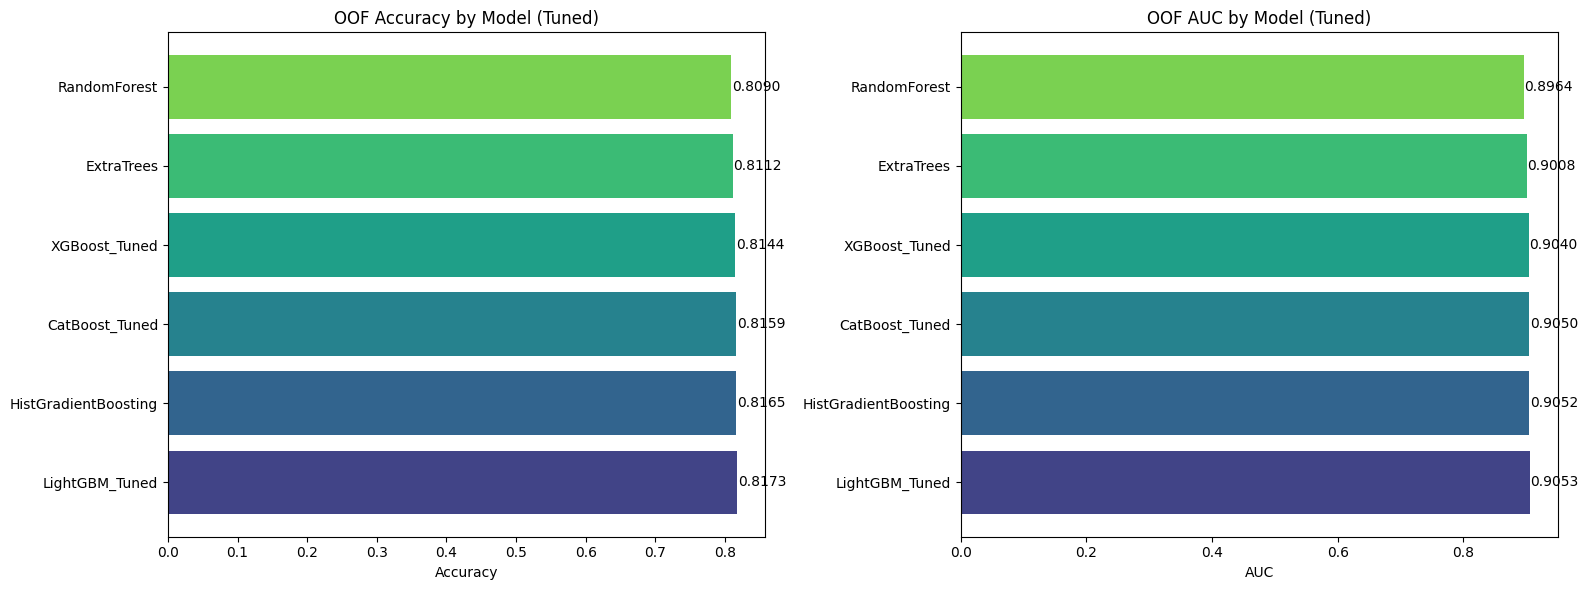

In [18]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy 비교
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
axes[0].barh(comparison_df['Model'], comparison_df['OOF Accuracy'], color=colors)
axes[0].set_title('OOF Accuracy by Model (Tuned)')
axes[0].set_xlabel('Accuracy')
for i, (acc, model) in enumerate(zip(comparison_df['OOF Accuracy'], comparison_df['Model'])):
    axes[0].text(acc + 0.001, i, f'{acc:.4f}', va='center')

# AUC 비교
axes[1].barh(comparison_df['Model'], comparison_df['OOF AUC'], color=colors)
axes[1].set_title('OOF AUC by Model (Tuned)')
axes[1].set_xlabel('AUC')
for i, (auc, model) in enumerate(zip(comparison_df['OOF AUC'], comparison_df['Model'])):
    axes[1].text(auc + 0.001, i, f'{auc:.4f}', va='center')

plt.tight_layout()
plt.show()

---
# Part 3: 고급 앙상블
---

## 10. Optuna 앙상블 가중치 최적화

In [19]:
# OOF 예측을 사용하여 최적 가중치 찾기
def objective_ensemble(trial):
    # 각 모델의 가중치
    w_lgb = trial.suggest_float('w_lgb', 0, 1)
    w_xgb = trial.suggest_float('w_xgb', 0, 1)
    w_cat = trial.suggest_float('w_cat', 0, 1)
    w_rf = trial.suggest_float('w_rf', 0, 1)
    w_et = trial.suggest_float('w_et', 0, 1)
    w_hgb = trial.suggest_float('w_hgb', 0, 1)
    
    # 가중치 정규화
    total = w_lgb + w_xgb + w_cat + w_rf + w_et + w_hgb
    if total == 0:
        return 0
    
    w_lgb, w_xgb, w_cat, w_rf, w_et, w_hgb = (
        w_lgb/total, w_xgb/total, w_cat/total, w_rf/total, w_et/total, w_hgb/total
    )
    
    # 가중 평균 예측
    oof_ensemble = (
        oof_predictions['LightGBM_Tuned'] * w_lgb +
        oof_predictions['XGBoost_Tuned'] * w_xgb +
        oof_predictions['CatBoost_Tuned'] * w_cat +
        oof_predictions['RandomForest'] * w_rf +
        oof_predictions['ExtraTrees'] * w_et +
        oof_predictions['HistGradientBoosting'] * w_hgb
    )
    
    oof_preds = (oof_ensemble >= 0.5).astype(int)
    return accuracy_score(y_train, oof_preds)

print("="*60)
print("Optuna 앙상블 가중치 최적화")
print("="*60)

study_ensemble = optuna.create_study(direction='maximize', sampler=sampler)
study_ensemble.optimize(objective_ensemble, n_trials=100, show_progress_bar=True)

print(f"\nBest Ensemble Score: {study_ensemble.best_value:.4f}")
print(f"Best Weights: {study_ensemble.best_params}")

Optuna 앙상블 가중치 최적화


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.814909:   0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 1. Best value: 0.815024:   1%|          | 1/100 [00:00<00:00, 322.42it/s]

Best trial: 2. Best value: 0.815254:   2%|▏         | 2/100 [00:00<00:00, 326.10it/s]

Best trial: 3. Best value: 0.816749:   3%|▎         | 3/100 [00:00<00:00, 392.63it/s]

Best trial: 3. Best value: 0.816749:   4%|▍         | 4/100 [00:00<00:00, 436.55it/s]

Best trial: 3. Best value: 0.816749:   5%|▌         | 5/100 [00:00<00:00, 447.49it/s]

Best trial: 3. Best value: 0.816749:   6%|▌         | 6/100 [00:00<00:00, 473.13it/s]

Best trial: 3. Best value: 0.816749:   7%|▋         | 7/100 [00:00<00:00, 476.46it/s]

Best trial: 3. Best value: 0.816749:   8%|▊         | 8/100 [00:00<00:00, 479.27it/s]

Best trial: 3. Best value: 0.816749:   9%|▉         | 9/100 [00:00<00:00, 494.59it/s]

Best trial: 3. Best value: 0.816749:  10%|█         | 10/100 [00:00<00:00, 403.90it/s]

Best trial: 3. Best value: 0.816749:  11%|█         | 11/100 [00:00<00:00, 345.47it/s]

Best trial: 12. Best value: 0.817554:  12%|█▏        | 12/100 [00:00<00:00, 311.11it/s]

Best trial: 12. Best value: 0.817554:  13%|█▎        | 13/100 [00:00<00:00, 285.06it/s]

Best trial: 12. Best value: 0.817554:  14%|█▍        | 14/100 [00:00<00:00, 268.56it/s]

Best trial: 12. Best value: 0.817554:  15%|█▌        | 15/100 [00:00<00:00, 253.39it/s]

Best trial: 12. Best value: 0.817554:  16%|█▌        | 16/100 [00:00<00:00, 240.87it/s]

Best trial: 12. Best value: 0.817554:  17%|█▋        | 17/100 [00:00<00:00, 234.47it/s]

Best trial: 12. Best value: 0.817554:  18%|█▊        | 18/100 [00:00<00:00, 224.61it/s]

Best trial: 12. Best value: 0.817554:  19%|█▉        | 19/100 [00:00<00:00, 220.47it/s]

Best trial: 12. Best value: 0.817554:  20%|██        | 20/100 [00:00<00:00, 213.24it/s]

Best trial: 12. Best value: 0.817554:  21%|██        | 21/100 [00:00<00:00, 208.24it/s]

Best trial: 12. Best value: 0.817554:  22%|██▏       | 22/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  22%|██▏       | 22/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  23%|██▎       | 23/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  24%|██▍       | 24/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  25%|██▌       | 25/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  26%|██▌       | 26/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  27%|██▋       | 27/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  28%|██▊       | 28/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  29%|██▉       | 29/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  30%|███       | 30/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  31%|███       | 31/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  32%|███▏      | 32/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  33%|███▎      | 33/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  34%|███▍      | 34/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  35%|███▌      | 35/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  36%|███▌      | 36/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  37%|███▋      | 37/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  38%|███▊      | 38/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  39%|███▉      | 39/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  40%|████      | 40/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  41%|████      | 41/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  42%|████▏     | 42/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  43%|████▎     | 43/100 [00:00<00:00, 218.15it/s]

Best trial: 12. Best value: 0.817554:  44%|████▍     | 44/100 [00:00<00:00, 170.42it/s]

Best trial: 12. Best value: 0.817554:  44%|████▍     | 44/100 [00:00<00:00, 170.42it/s]

Best trial: 12. Best value: 0.817554:  45%|████▌     | 45/100 [00:00<00:00, 170.42it/s]

Best trial: 12. Best value: 0.817554:  46%|████▌     | 46/100 [00:00<00:00, 170.42it/s]

Best trial: 47. Best value: 0.817669:  47%|████▋     | 47/100 [00:00<00:00, 170.42it/s]

Best trial: 48. Best value: 0.817784:  48%|████▊     | 48/100 [00:00<00:00, 170.42it/s]

Best trial: 48. Best value: 0.817784:  49%|████▉     | 49/100 [00:00<00:00, 170.42it/s]

Best trial: 48. Best value: 0.817784:  50%|█████     | 50/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  51%|█████     | 51/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  52%|█████▏    | 52/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  53%|█████▎    | 53/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  54%|█████▍    | 54/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  55%|█████▌    | 55/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  56%|█████▌    | 56/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  57%|█████▋    | 57/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  58%|█████▊    | 58/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  59%|█████▉    | 59/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  60%|██████    | 60/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  61%|██████    | 61/100 [00:00<00:00, 170.42it/s]

Best trial: 51. Best value: 0.818014:  62%|██████▏   | 62/100 [00:00<00:00, 161.27it/s]

Best trial: 51. Best value: 0.818014:  62%|██████▏   | 62/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  63%|██████▎   | 63/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  64%|██████▍   | 64/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  65%|██████▌   | 65/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  66%|██████▌   | 66/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  67%|██████▋   | 67/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  68%|██████▊   | 68/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  69%|██████▉   | 69/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  70%|███████   | 70/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  71%|███████   | 71/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  72%|███████▏  | 72/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  73%|███████▎  | 73/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  74%|███████▍  | 74/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  75%|███████▌  | 75/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  76%|███████▌  | 76/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  77%|███████▋  | 77/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  78%|███████▊  | 78/100 [00:00<00:00, 161.27it/s]

Best trial: 63. Best value: 0.818245:  79%|███████▉  | 79/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  79%|███████▉  | 79/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  80%|████████  | 80/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  81%|████████  | 81/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  82%|████████▏ | 82/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  83%|████████▎ | 83/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  84%|████████▍ | 84/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  85%|████████▌ | 85/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  86%|████████▌ | 86/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  87%|████████▋ | 87/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  88%|████████▊ | 88/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  89%|████████▉ | 89/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  90%|█████████ | 90/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  91%|█████████ | 91/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  92%|█████████▏| 92/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  93%|█████████▎| 93/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  94%|█████████▍| 94/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  95%|█████████▌| 95/100 [00:00<00:00, 159.52it/s]

Best trial: 63. Best value: 0.818245:  96%|█████████▌| 96/100 [00:00<00:00, 159.26it/s]

Best trial: 63. Best value: 0.818245:  96%|█████████▌| 96/100 [00:00<00:00, 159.26it/s]

Best trial: 63. Best value: 0.818245:  97%|█████████▋| 97/100 [00:00<00:00, 159.26it/s]

Best trial: 63. Best value: 0.818245:  98%|█████████▊| 98/100 [00:00<00:00, 159.26it/s]

Best trial: 63. Best value: 0.818245:  99%|█████████▉| 99/100 [00:00<00:00, 159.26it/s]

Best trial: 63. Best value: 0.818245: 100%|██████████| 100/100 [00:00<00:00, 162.97it/s]


Best Ensemble Score: 0.8182
Best Weights: {'w_lgb': 0.527413935406328, 'w_xgb': 0.20500208412826942, 'w_cat': 0.9293045846143647, 'w_rf': 0.8926872313846469, 'w_et': 0.104769732537633, 'w_hgb': 0.6724529179457236}


In [20]:
# 최적 가중치로 앙상블 예측
best_weights = study_ensemble.best_params
total = sum(best_weights.values())
normalized_weights = {k: v/total for k, v in best_weights.items()}

print("정규화된 가중치:")
for k, v in normalized_weights.items():
    print(f"  {k}: {v:.4f}")

# OOF 앙상블 예측
oof_optuna_ensemble = (
    oof_predictions['LightGBM_Tuned'] * normalized_weights['w_lgb'] +
    oof_predictions['XGBoost_Tuned'] * normalized_weights['w_xgb'] +
    oof_predictions['CatBoost_Tuned'] * normalized_weights['w_cat'] +
    oof_predictions['RandomForest'] * normalized_weights['w_rf'] +
    oof_predictions['ExtraTrees'] * normalized_weights['w_et'] +
    oof_predictions['HistGradientBoosting'] * normalized_weights['w_hgb']
)

# Test 앙상블 예측
test_optuna_ensemble = (
    test_predictions['LightGBM_Tuned'] * normalized_weights['w_lgb'] +
    test_predictions['XGBoost_Tuned'] * normalized_weights['w_xgb'] +
    test_predictions['CatBoost_Tuned'] * normalized_weights['w_cat'] +
    test_predictions['RandomForest'] * normalized_weights['w_rf'] +
    test_predictions['ExtraTrees'] * normalized_weights['w_et'] +
    test_predictions['HistGradientBoosting'] * normalized_weights['w_hgb']
)

optuna_acc = accuracy_score(y_train, (oof_optuna_ensemble >= 0.5).astype(int))
optuna_auc = roc_auc_score(y_train, oof_optuna_ensemble)

print(f"\nOptuna Ensemble:")
print(f"  OOF Accuracy: {optuna_acc:.4f}")
print(f"  OOF AUC: {optuna_auc:.4f}")

cv_results['Optuna_Ensemble'] = {'oof_acc': optuna_acc, 'oof_auc': optuna_auc, 'fold_scores': [optuna_acc]}
oof_predictions['Optuna_Ensemble'] = oof_optuna_ensemble
test_predictions['Optuna_Ensemble'] = test_optuna_ensemble

정규화된 가중치:
  w_lgb: 0.1583
  w_xgb: 0.0615
  w_cat: 0.2789
  w_rf: 0.2679
  w_et: 0.0314
  w_hgb: 0.2018

Optuna Ensemble:
  OOF Accuracy: 0.8182
  OOF AUC: 0.9069


## 11. 고급 스태킹 앙상블

In [21]:
print("="*60)
print("고급 Stacking Ensemble (다양한 메타 학습기)")
print("="*60)

# 기본 모델 정의 (튜닝된 파라미터 사용)
base_estimators = [
    ('lgb', lgb.LGBMClassifier(**lgb_best_params)),
    ('xgb', xgb.XGBClassifier(**xgb_best_params)),
    ('cat', CatBoostClassifier(**cat_best_params)),
    ('rf', RandomForestClassifier(**rf_best_params)),
    ('et', ExtraTreesClassifier(**et_best_params)),
    ('hgb', HistGradientBoostingClassifier(**hgb_best_params))
]

# Stacking with LightGBM as meta-learner
stacking_lgb = StackingClassifier(
    estimators=base_estimators,
    final_estimator=lgb.LGBMClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3,
        random_state=RANDOM_STATE, verbosity=-1
    ),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Cross-validation
stacking_scores = cross_val_score(stacking_lgb, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Stacking (LightGBM Meta) CV Accuracy: {stacking_scores.mean():.4f} (+/- {stacking_scores.std():.4f})")

# 전체 데이터로 학습
stacking_lgb.fit(X_train, y_train)
stacking_test_probs = stacking_lgb.predict_proba(X_test)[:, 1]

cv_results['Stacking_LGB'] = {'cv_mean': stacking_scores.mean(), 'cv_std': stacking_scores.std(), 
                              'oof_acc': stacking_scores.mean(), 'fold_scores': stacking_scores.tolist()}
test_predictions['Stacking_LGB'] = stacking_test_probs

고급 Stacking Ensemble (다양한 메타 학습기)


Stacking (LightGBM Meta) CV Accuracy: 0.8134 (+/- 0.0079)


## 12. Soft Voting (모든 모델)

In [22]:
print("="*60)
print("Soft Voting Ensemble (6 Models)")
print("="*60)

# Soft Voting
voting_all = VotingClassifier(
    estimators=base_estimators,
    voting='soft',
    n_jobs=-1
)

# Cross-validation
voting_scores = cross_val_score(voting_all, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Soft Voting (6 Models) CV Accuracy: {voting_scores.mean():.4f} (+/- {voting_scores.std():.4f})")

# 전체 데이터로 학습
voting_all.fit(X_train, y_train)
voting_test_probs = voting_all.predict_proba(X_test)[:, 1]

cv_results['Voting_All'] = {'cv_mean': voting_scores.mean(), 'cv_std': voting_scores.std(),
                            'oof_acc': voting_scores.mean(), 'fold_scores': voting_scores.tolist()}
test_predictions['Voting_All'] = voting_test_probs

Soft Voting Ensemble (6 Models)


Soft Voting (6 Models) CV Accuracy: 0.8157 (+/- 0.0078)


## 13. 단순 평균 앙상블 (Blending)

In [23]:
print("="*60)
print("Simple Average Ensemble (6 Models)")
print("="*60)

# 단순 평균
oof_avg = (
    oof_predictions['LightGBM_Tuned'] +
    oof_predictions['XGBoost_Tuned'] +
    oof_predictions['CatBoost_Tuned'] +
    oof_predictions['RandomForest'] +
    oof_predictions['ExtraTrees'] +
    oof_predictions['HistGradientBoosting']
) / 6

test_avg = (
    test_predictions['LightGBM_Tuned'] +
    test_predictions['XGBoost_Tuned'] +
    test_predictions['CatBoost_Tuned'] +
    test_predictions['RandomForest'] +
    test_predictions['ExtraTrees'] +
    test_predictions['HistGradientBoosting']
) / 6

avg_acc = accuracy_score(y_train, (oof_avg >= 0.5).astype(int))
avg_auc = roc_auc_score(y_train, oof_avg)

print(f"Simple Average (6 Models):")
print(f"  OOF Accuracy: {avg_acc:.4f}")
print(f"  OOF AUC: {avg_auc:.4f}")

cv_results['Simple_Avg_6'] = {'oof_acc': avg_acc, 'oof_auc': avg_auc, 'fold_scores': [avg_acc]}
test_predictions['Simple_Avg_6'] = test_avg

Simple Average Ensemble (6 Models)
Simple Average (6 Models):
  OOF Accuracy: 0.8157
  OOF AUC: 0.9066


## 14. 최종 성능 비교

In [24]:
# 최종 결과 정리
final_models = [
    'LightGBM_Tuned', 'XGBoost_Tuned', 'CatBoost_Tuned',
    'RandomForest', 'ExtraTrees', 'HistGradientBoosting',
    'Optuna_Ensemble', 'Stacking_LGB', 'Voting_All', 'Simple_Avg_6'
]

final_results = pd.DataFrame({
    'Model': final_models,
    'Score': [cv_results[m]['oof_acc'] if 'oof_acc' in cv_results[m] else cv_results[m]['cv_mean'] 
              for m in final_models]
}).sort_values('Score', ascending=False)

print("\n" + "="*70)
print("최종 모델 성능 비교 (높은 순)")
print("="*70)
print(final_results.to_string(index=False))


최종 모델 성능 비교 (높은 순)
               Model    Score
     Optuna_Ensemble 0.818245
      LightGBM_Tuned 0.817324
HistGradientBoosting 0.816519
      CatBoost_Tuned 0.815944
          Voting_All 0.815714
        Simple_Avg_6 0.815714
       XGBoost_Tuned 0.814448
        Stacking_LGB 0.813413
          ExtraTrees 0.811227
        RandomForest 0.809042


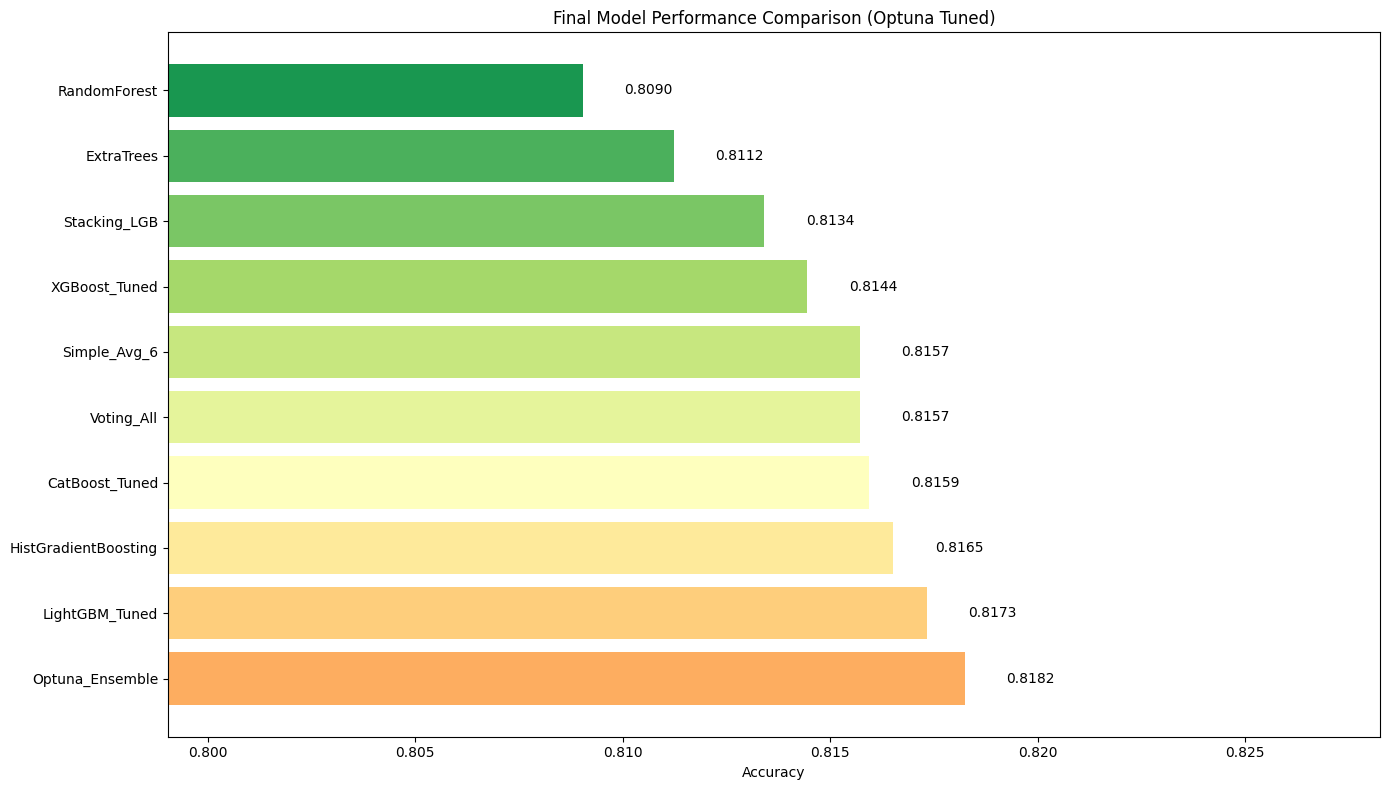

In [25]:
# 최종 시각화
plt.figure(figsize=(14, 8))
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(final_results)))
bars = plt.barh(final_results['Model'], final_results['Score'], color=colors)
plt.xlabel('Accuracy')
plt.title('Final Model Performance Comparison (Optuna Tuned)')
plt.xlim([min(final_results['Score']) - 0.01, max(final_results['Score']) + 0.01])

for bar, score in zip(bars, final_results['Score']):
    plt.text(score + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 15. 제출 파일 생성

In [26]:
# 최고 성능 모델 확인
best_model = final_results.iloc[0]['Model']
print(f"Best Model: {best_model}")

# 각 모델별 제출 파일 생성
submissions = {}
for model_name in final_models:
    if model_name in test_predictions:
        submissions[model_name.lower()] = (test_predictions[model_name] >= 0.5).astype(bool)

Best Model: Optuna_Ensemble


In [27]:
# 모든 제출 파일 생성
for name, preds in submissions.items():
    submission = pd.DataFrame({
        'PassengerId': test_ids,
        'Transported': preds
    })
    submission.to_csv(f'../submissions/submission_{name}.csv', index=False)
    print(f"Saved: submission_{name}.csv")

print("\n모든 제출 파일 생성 완료!")

Saved: submission_lightgbm_tuned.csv
Saved: submission_xgboost_tuned.csv
Saved: submission_catboost_tuned.csv
Saved: submission_randomforest.csv
Saved: submission_extratrees.csv
Saved: submission_histgradientboosting.csv
Saved: submission_optuna_ensemble.csv
Saved: submission_stacking_lgb.csv
Saved: submission_voting_all.csv
Saved: submission_simple_avg_6.csv

모든 제출 파일 생성 완료!


In [28]:
# Best 제출 파일 확인
best_submission_name = best_model.lower()
best_submission = pd.read_csv(f'../submissions/submission_{best_submission_name}.csv')
print(f"Best Submission ({best_model}):")
print(best_submission.head(10))
print(f"\nShape: {best_submission.shape}")
print(f"\nTransported 분포:")
print(best_submission['Transported'].value_counts())

Best Submission (Optuna_Ensemble):
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01         True
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01         True

Shape: (4277, 2)

Transported 분포:
Transported
True     2216
False    2061
Name: count, dtype: int64


## 16. 모델 저장

In [29]:
# Optuna 스터디 결과 저장
optuna_results = {
    'lgb_best_params': lgb_best_params,
    'xgb_best_params': xgb_best_params,
    'cat_best_params': cat_best_params,
    'rf_best_params': rf_best_params,
    'et_best_params': et_best_params,
    'hgb_best_params': hgb_best_params,
    'ensemble_weights': normalized_weights
}

with open('../models/optuna_best_params.pkl', 'wb') as f:
    pickle.dump(optuna_results, f)

# 앙상블 모델 저장
with open('../models/stacking_lgb_meta.pkl', 'wb') as f:
    pickle.dump(stacking_lgb, f)

with open('../models/voting_all.pkl', 'wb') as f:
    pickle.dump(voting_all, f)

print("모델 저장 완료!")
print("\n저장된 파일:")
print("- models/optuna_best_params.pkl")
print("- models/stacking_lgb_meta.pkl")
print("- models/voting_all.pkl")

모델 저장 완료!

저장된 파일:
- models/optuna_best_params.pkl
- models/stacking_lgb_meta.pkl
- models/voting_all.pkl


## 17. 결론

### 적용된 개선 사항
1. **Optuna 하이퍼파라미터 튜닝**: LightGBM, XGBoost, CatBoost, RandomForest, ExtraTrees, HistGradientBoosting
2. **추가 모델**: RandomForest, ExtraTrees, HistGradientBoosting
3. **다양한 앙상블**:
   - Optuna 가중치 최적화 앙상블
   - 6개 모델 Stacking (LightGBM 메타 학습기)
   - 6개 모델 Soft Voting
   - 6개 모델 단순 평균

### 추천 제출 파일
1. 가장 높은 점수를 기록한 모델의 submission 파일
2. `submission_optuna_ensemble.csv` - Optuna 가중치 최적화 앙상블
3. `submission_stacking_lgb.csv` - 고급 스태킹 앙상블

In [30]:
print("="*60)
print("모델링 완료!")
print("="*60)
print(f"\nBest Model: {best_model}")
print(f"Best Score: {final_results.iloc[0]['Score']:.4f}")
print(f"\n추천 제출: submission_{best_submission_name}.csv")

모델링 완료!

Best Model: Optuna_Ensemble
Best Score: 0.8182

추천 제출: submission_optuna_ensemble.csv
